# **Superconductivity Regression Notebook**
Trains models to predict critical temperatures based on features found with "*../code/get_featurizers.ipynb*". Imports data from "*../data/supercon_feat.csv*", which is produced in *get_featurizers.ipynb*. The orginal data is from the supercon database. This notebook is to produce results in a graphical format, in bulk

*Author: Kirk Kleinsasser*

In [3]:
import dill
#dill.load_session('../data/latest-run.db') #this can load a saved python session so I don't need to rerun computationally expensive cells
%autosave 300 
#autosaves code every five minutes

Autosaving every 300 seconds


In [4]:
#TODO: Add MAE metric. Do SVR optimization. Redo extratrees optimzation with just n_est. Try RFR more. Try Superlearner more. Elbow method for kmeans.

#TODO: maybe do comparision of params vs scores
#physics-informed ML 
#lolopy - uncertainty, at least for RFR
#citrine informatics 

## Import Libraries / Define Import Data Function

In [5]:
#general imports:
import warnings #to suppress grid search warnings
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #heatmaps

#regression models:
from mlens.ensemble import SuperLearner
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.svm import SVR
from xgboost import XGBRegressor

#various ML tools:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_predict, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, max_error
from skopt import BayesSearchCV #bayesian optimization

#imports the data from get_featurizers. Function because some models we may want infinity:
def import_data(replace_inf=False):
    global data, target, train_data, test_data, train_target, test_target #variables that we want to define globally (outside of this funtion)
    data = pd.DataFrame(pd.read_csv('../data/supercon_features.csv')) #loads data produced in get_featurizer.ipynb
    target = data.pop('Tc') #remove target (critical temp) from data

    if replace_inf: #replaces values of infinity with NaN if replace_inf is True
        data.replace([np.inf, -np.inf], np.nan, inplace=True) 

    #TODO: debug feaurizers - NaN is entered when there is an error in the featurizer
    data.drop(['name','Unnamed: 0', 'composition'], axis=1, inplace=True) #drop columns irrelevant to training
    data = data[data.columns[data.notnull().any()]] #drop columns that are entirely NaN (12 columns) 

    for col in data: #replaces NaN with zeros
        data[col] = pd.to_numeric(data[col], errors ='coerce').fillna(0).astype('float')

    #creates a test train split, with shuffle and random state for reproducibility 
    train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.15, random_state=43, shuffle=True)

[MLENS] backend: threading


## Evaluation Functions
To train models and return results

In [6]:
def evaluate_one(model_name, regressor, parameters): #define function that trains a model and prints scores and plots
    global train_data, train_data, test_data, test_target #we need these variables and don't want to pass them as arguments
    with plt.rc_context({'xtick.color':'white', 'ytick.color':'white','axes.titlecolor':'white','figure.facecolor':'#1e1e1e','text.color':'white','legend.labelcolor':'black'}):
        plt.title(f"{model_name} - Prediction vs. Actual Value (CV)", color='white')
        model = regressor(**parameters) #unpacks model and params
        model.fit(train_data.values, train_target.values) #fit the model
        model_pred = model.predict(test_data) #make predictions on test data

        mse = round(mean_squared_error(test_target, model_pred),3) #find mean square error
        mae = round(mean_absolute_error(test_target, model_pred),3) #find mean square error
        r_squared = round(r2_score(test_target, model_pred),3) #find r2 score

        #make our plot - with plt.rc_context sets theme to look good in dark mode
        difference = np.abs(test_target - model_pred) #function that finds the absolute difference between predicted and actual value
        im = plt.scatter(model_pred, test_target, cmap='plasma_r', norm=plt.Normalize(0, 120), c=difference, label="Critical Temperature (K)") #create scatter plot of data 
        plt.plot((0,135), (0,135), 'k--', alpha=0.75) #add expected line. Values must be changed with different data to look good
        plt.title(model_name, c='white')
        plt.ylabel('Prediction', c='white')
        plt.xlabel('Actual Value', c='white')
        plt.annotate(f'R2: {r_squared}', xy = (0, -0.15), xycoords='axes fraction', ha='left', va="center", fontsize=10) #add footnote with R2 
        plt.annotate(f'MAXE: {maxe}', xy = (0, -0.20), xycoords='axes fraction', ha='left', va="center", fontsize=10) #add footnote with R2 
        plt.annotate(f'MAE: {mae}', xy = (1.0, -0.20), xycoords='axes fraction', ha='right', va="center", fontsize=10) #add footnote with MAE
        plt.annotate(f'MSE: {mse}', xy = (1.0, -0.15), xycoords='axes fraction', ha='right', va="center", fontsize=10) #add footnote with MSE
        plt.legend()
        plt.colorbar().set_label(label="Difference from Actual (K)", color='white') #using .set_label() as colorbar() does accept color arguments
        plt.show()

In [7]:
def evaluate(models, title): #define function that trains up to eight models at once plots with each model in a subplot. Includes model scores
    global train_data, train_data, test_data, test_target #we need these variables and don't want to pass them as arguments
    import_data(replace_inf=True)
    with plt.rc_context({'xtick.color':'white', 'ytick.color':'white','axes.titlecolor':'white','figure.facecolor':'#181a1b','text.color':'white','legend.labelcolor':'black'}):
        fig, ax = plt.subplots(2, 4, sharey='row', figsize=(28,10))
        fig.subplots_adjust(hspace=0.35)
        fig.suptitle(title, color='white', size=16)
        for [model_name, regressor, parameters, ax1, ax2] in models:
            model = regressor(**parameters) #unpacks model and params
            model.fit(train_data, train_target) #fit the model
            model_pred = model.predict(test_data) #make predictions on test data

            mse = round(mean_squared_error(test_target, model_pred),3) #find mean square error
            mae = round(mean_absolute_error(test_target, model_pred),3) #find mean square error
            maxe = round(max_error(test_target, model_pred),3)
            r_squared = round(r2_score(test_target, model_pred),3) #find r2 score

            #make our plot - with plt.rc_context sets theme to look good in dark mode
            difference = np.abs(test_target - model_pred) #function that finds the absolute difference between predicted and actual value
            im = ax[ax1, ax2].scatter(model_pred, test_target, cmap='plasma_r', norm=plt.Normalize(0, 120), c=difference, label="Critical Temperature (K)") #create scatter plot of data 
            ax[ax1, ax2].plot((0,135), (0,135), 'k--', alpha=0.75) #add expected line. Values must be changed with different data to look good
            ax[ax1, ax2].set_title(model_name, c='white')
            ax[ax1, ax2].set_xlabel('Prediction', c='white')
            ax[ax1, ax2].set_ylabel('Actual Value', c='white')
            ax[ax1, ax2].annotate(f'R2: {r_squared}', xy = (0, -0.15), xycoords='axes fraction', ha='left', va="center", fontsize=10) #add footnote with R2 
            ax[ax1, ax2].annotate(f'MAXE: {maxe}', xy = (0, -0.20), xycoords='axes fraction', ha='left', va="center", fontsize=10) #add footnote with R2 
            ax[ax1, ax2].annotate(f'MAE: {mae}', xy = (1.0, -0.20), xycoords='axes fraction', ha='right', va="center", fontsize=10) #add footnote with MAE
            ax[ax1, ax2].annotate(f'MSE: {mse}', xy = (1.0, -0.15), xycoords='axes fraction', ha='right', va="center", fontsize=10) #add footnote with MSE

        handles, labels = ax[0,0].get_legend_handles_labels()
        fig.legend(handles=handles,loc='lower center')

        fig.colorbar(im, ax=ax.ravel().tolist()).set_label(label="Difference from Actual (K)", color='white') #using .set_label() as colorbar() does accept color arguments
        
        plt.savefig('../data/results.png', bbox_inches='tight')
        plt.show()

## Results

TypeError: show() got an unexpected keyword argument 'bbox_inches'

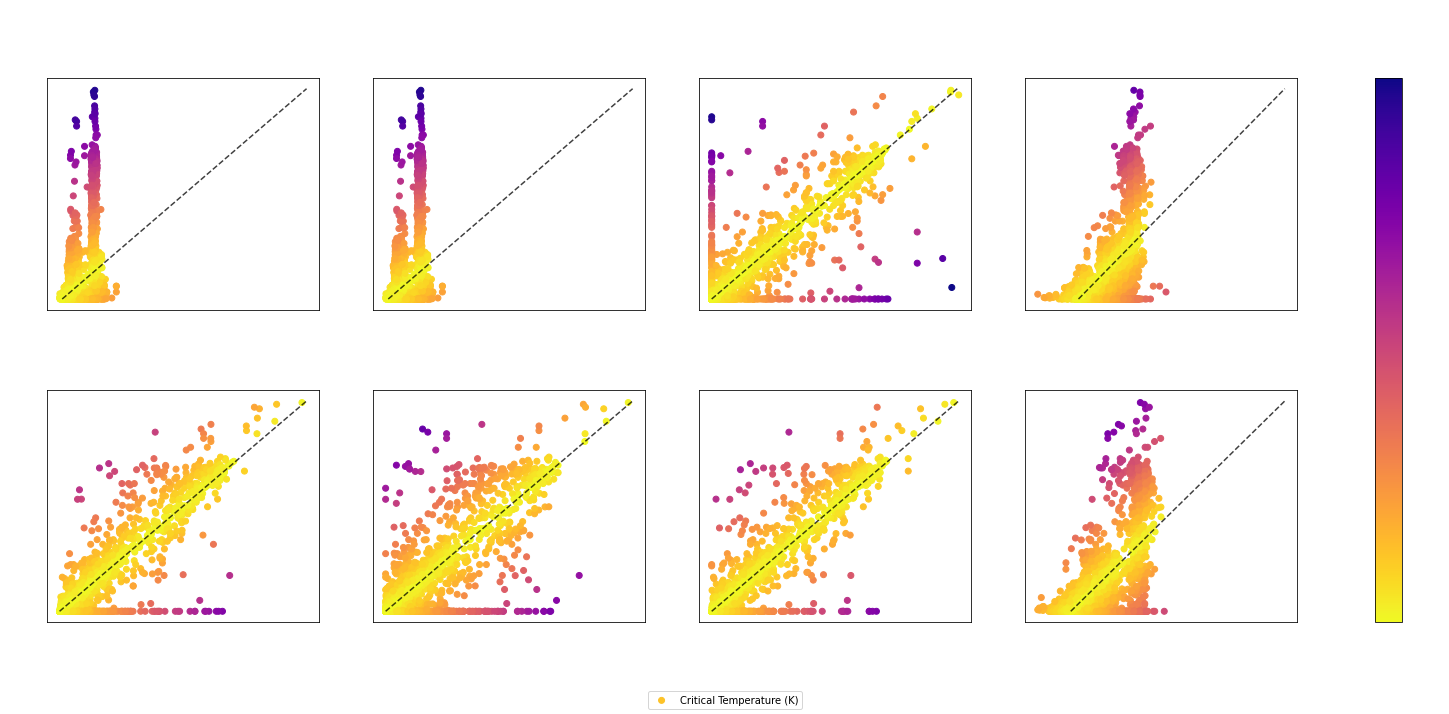

In [8]:
models =   [["Support Vector Machines (Linear)", SVR, {}, 0, 0],
            ["Random Forest Regression", RandomForestRegressor, {}, 1, 0],
            ["Support Vector Machines (Poly)", SVR, {}, 0, 1],
            ["KNeighbors Regression", KNeighborsRegressor, {}, 1, 1],
            ["Decision Tree Regression", DecisionTreeRegressor, {}, 0, 2],
            ["Extra Trees Regression", ExtraTreesRegressor, {}, 1, 2],
            ["Elastic Net Regression", ElasticNet, {}, 0, 3],
            ["Bayesian Regression", BayesianRidge, {}, 1, 3]]
evaluate(models, "Prediction vs. Actual Value (CV) - Unoptimized") #call evaluation function

In [25]:
models  =  [["Support Vector Machines", SVR, {'C':1, 'epsilon':10, 'gamma':'auto', 'kernel':'linear'}, 0, 0],
            ["Random Forest Regression", RandomForestRegressor, {}, 1, 0],
            # ["", , {}, 0, 1],
            ["KNeighbors Regression", KNeighborsRegressor, {'metric':'manhattan', 'n_jobs':-1, 'n_neighbors':5}, 1, 1],
            ["Decision Tree Regression", DecisionTreeRegressor, {'criterion':'poisson', 'max_features':0.5, 'random_state':43}, 0, 2],
            ["Extra Trees Regression", ExtraTreesRegressor, {}, 1, 2],
            ["Elastic Net Regression", ElasticNet, {'alpha':1e-05, 'l1_ratio':0.0}, 0, 3],
            ["Bayesian Regression", BayesianRidge, {}, 1, 3]]
evaluate(models, "Prediction vs. Actual Value (CV) - Optimized")

In [72]:
# create a list of base-models for superlearner
def get_models():
	models = list()
	models.append(SVR())
	# models.append(SVR())
	models.append(ElasticNet(alpha=1e-05, l1_ratio=0.0))
	models.append(DecisionTreeRegressor())
	models.append(RandomForestRegressor())
	models.append(KNeighborsRegressor(metric='manhattan', n_jobs=-1, n_neighbors=5))
	# models.append(ExtraTreesRegressor())
	# models.append(SGDRegressor(alpha=1000.0, loss='epsilon_insensitive', max_iter=1500, penalty='l1'))
	# models.append(BayesianRidge(alpha_init=1.2, lambda_init=0.0001))

	return models

In [73]:
def get_super_learner(X):
	ensemble = SuperLearner(scorer=r2_score, folds=10, shuffle=True, sample_size=len(X), random_state=43)
	# add base models
	models = get_models()
	ensemble.add(models)
	# add the meta model
	ensemble.add_meta(LinearRegression())

	return ensemble
ensemble = get_super_learner(train_data)

In [16]:
# dill.dump_session('../data/supercon_ml_latest_run.db') #this can dump a python session so I can resume later, after restarts and such